In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizer_v2.adam import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
import pandas as pd


import cv2
import os

import numpy as np

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
root = 'drive/My Drive/Colab Notebooks/'
reda_root = 'drive/My Drive/TFG/'
paht = 'drive/My Drive/Colab Notebooks/fakkedit/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
MULTIMODAL_ONLY = True # if False, we will load all the
nameFile = 'multimodal_'
if not MULTIMODAL_ONLY:
    nameFile ='all_'
TYPE_CLASSIFICATION = 6 # 2, 3 OR 6

In [13]:
import pandas as pd
train = pd.read_csv(reda_root+"data/fakeddit/" + nameFile+ "train.tsv", sep='\t')
val  = pd.read_csv(reda_root+"data/fakeddit/" + nameFile+ "validate.tsv", sep='\t')
test  = pd.read_csv(reda_root+"data/fakeddit/" + nameFile+ "test_public.tsv", sep='\t')
images = pd.read_csv(reda_root+'./images.csv')
images.rename(columns = {'Name':'id'}, inplace = True)

print("Dataset: ", nameFile)
print('size training: ', len(train))
print('size validation: ', len(val))
print('size test: ', len(test))

Dataset:  multimodal_
size training:  564000
size validation:  59342
size test:  59319


In [18]:
all = pd.concat([train, val, test])
all

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0
1,VIDCAs17,this concerned sink with a tiny hat,1.534727e+09,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,This concerned sink with a tiny hat,0.99,0,2,2
2,prometheus1123,hackers leak emails from uae ambassador to us,1.496511e+09,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,Hackers leak emails from UAE ambassador to US,0.92,1,0,0
3,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0
4,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59314,lazarus30d,bicycle taxi drivers of new delhi,1.352463e+09,flickr.com,True,12wreq,https://external-preview.redd.it/mWhXZymnupI3a...,NaN,0.0,4,pic,Bicycle taxi drivers of New Delhi,0.64,1,0,0
59315,Sewblon,trump blows up gops formula for winning house ...,1.533888e+09,politico.com,True,9650zw,https://external-preview.redd.it/1uLpjM1bd_vA-...,NaN,1.0,2,neutralnews,Trump blows up GOP's formula for winning House...,0.58,1,0,0
59316,Lifewillbelife,napoleon returns from his exile on the island ...,1.521720e+09,i.redd.it,True,86ax7x,https://preview.redd.it/fuzkuzxt0bn01.png?widt...,NaN,0.0,45,fakehistoryporn,Napoleon returns from his exile on the island ...,0.98,0,2,2
59317,LordCamembert,deep down he always wanted to be a ballet dancer,1.366567e+09,NaN,True,c9jq15h,http://i.imgur.com/otCWbOt.jpg,1cssa3,NaN,141,psbattle_artwork,Deep down he always wanted to be a ballet dancer,NaN,0,2,4


In [15]:
images['id'] = images['id'].apply(lambda x: x.split('.')[0])
images

,id
0,737mcu
1,cv4pi7y
2,dkhfq81
3,d8qc4fs
4,dr2qy07
...,...
153451,796d3z
153452,awxhir
153453,8gnet9
153454,4xypkv


In [20]:
df_with_photo = all.merge(images, on='id')
df_with_photo

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0
1,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0
2,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2
3,happenpupe,major thermos,1.495660e+09,i.redd.it,True,6d50rl,https://preview.redd.it/l9gvkkf3jizy.jpg?width...,NaN,0.0,2,pareidolia,major thermos,0.67,0,2,2
4,all-top-today_SS,cutest baby cow ive seen in my head all day an...,1.509141e+09,i.redd.it,True,796d3z,https://preview.redd.it/mbj3et90gbuz.jpg?width...,NaN,21.0,141,subredditsimulator,Cutest baby cow I've seen in my head all day a...,0.99,0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135499,secretrebel,stacked stone koala house,1.534845e+09,i.redd.it,True,991t9a,https://preview.redd.it/4k7h8ne14fh11.jpg?widt...,NaN,0.0,4,pareidolia,Stacked stone koala house,0.75,0,2,2
135500,de-nnie,my grandparents during mid ties i guess on the...,1.558184e+09,i.redd.it,True,bq3nsk,https://preview.redd.it/g1c3rnbvuyy21.jpg?widt...,NaN,7.0,4,mildlyinteresting,My grandparents during mid 40-ties i guess on ...,0.65,1,0,0
135501,GetJaded,occasionally ill randomly find dvds when stepp...,1.565348e+09,i.redd.it,True,co0q3a,https://preview.redd.it/2qas9nhllef31.jpg?widt...,NaN,7.0,27,mildlyinteresting,Occasionally I'll randomly find DVDs when step...,0.83,1,0,0
135502,Fear-The-Patman,why is there a porter potty on the roof of my job,1.552688e+09,i.redd.it,True,b1l038,https://preview.redd.it/oojzsuurxcm21.jpg?widt...,NaN,8.0,5,mildlyinteresting,Why is there a porter potty on the roof of my job,0.73,1,0,0


In [28]:
traindata_all, validata_all, testdata_all = np.split(df_with_photo.sample(frac=1, random_state=12345), [int(.6*len(df_with_photo)), int(.8*len(df_with_photo))])
print('size training: ', len(traindata_all))
print('size validation: ', len(validata_all))
print('size test: ', len(testdata_all))

size training:  81302
size validation:  27101
size test:  27101


In [29]:
reduction = 2 #100, 10 or 1

print("reduction applied: ", reduction)


print(f"Training patterns before reduction: {len(traindata_all)}")
traindata_all = traindata_all.sample(int(len(traindata_all)/reduction), random_state=12345)
print(f"Training patterns after reduction:  {len(traindata_all)}")

print(f"Validation patterns before reduction: {len(validata_all)}")
validata_all = validata_all.sample(int(len(validata_all)/reduction), random_state=12345)
print(f"Validation patterns after reduction:  {len(validata_all)}")

print(f"Test patterns before reduction: {len(testdata_all)}")
testdata_all = testdata_all.sample(int(len(testdata_all)/reduction), random_state=12345)
print(f"Test patterns after reduction:  {len(testdata_all)}")

reduction applied:  2
Training patterns before reduction: 81302
Training patterns after reduction:  40651
Validation patterns before reduction: 27101
Validation patterns after reduction:  13550
Test patterns before reduction: 27101
Test patterns after reduction:  13550


In [ ]:
%cd drive/MyDrive/TFG

In [44]:
img_size = 224
def get_data(type, path, limit = -1):
    if type == 'train':
        source = traindata_all
    elif type == 'val':
        source  = validata_all
    elif type == 'test':
        source  = testdata_all
    iter = 0
    data = [] 
    for index, row in source.iterrows():
        iter+= 1
        if iter == limit:
            break
        try:
            img = row['id'] + '.jpg'
            class_num = row[str(TYPE_CLASSIFICATION) + +'_way_label']
            print('[' + str(index) + ']' + ' Trying img = ' + img + ' with class = ' + str(class_num) + ' for type = ' + type)
            img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
            resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
            data.append([resized_arr, class_num])
        except Exception as e:
           print(e)
           print('Error in row ' + str(index) + ' for image named ' + img)
    return np.array(data)

In [45]:
# Now we can easily fetch our train and validation data.
train = get_data('train', './public_image_set', 100)
val = get_data('val', './public_image_set', 100)

[131300] Trying img = dgy0yq.jpg with class = 0 for type = train
[120115] Trying img = 41syp1.jpg with class = 0 for type = train
[52398] Trying img = 5klad3.jpg with class = 2 for type = train
[122836] Trying img = cc842r5.jpg with class = 4 for type = train
[120742] Trying img = caiujmh.jpg with class = 4 for type = train
[125214] Trying img = ctrn2kk.jpg with class = 4 for type = train
[94277] Trying img = 3twkbr.jpg with class = 1 for type = train
[120506] Trying img = 9cq858.jpg with class = 2 for type = train
[130946] Trying img = 3lq1y0.jpg with class = 2 for type = train
[71551] Trying img = c8dgj10.jpg with class = 4 for type = train
[52667] Trying img = cfns13j.jpg with class = 4 for type = train
[102404] Trying img = brxoc6.jpg with class = 0 for type = train
[101440] Trying img = 83s3k1.jpg with class = 1 for type = train
[76312] Trying img = da1897.jpg with class = 1 for type = train
[17040] Trying img = c5s9zpe.jpg with class = 4 for type = train
[7443] Trying img = ck93i

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[90754] Trying img = cmc2red.jpg with class = 4 for type = val
[36850] Trying img = 8gvfhs.jpg with class = 5 for type = val
[51137] Trying img = cltjs3s.jpg with class = 4 for type = val
[10344] Trying img = c4l7df6.jpg with class = 4 for type = val
[117999] Trying img = 7wmlnz.jpg with class = 1 for type = val
[118035] Trying img = 4eatzy.jpg with class = 1 for type = val
[34176] Trying img = c9460t.jpg with class = 2 for type = val
[101992] Trying img = 3awpzy.jpg with class = 0 for type = val
[29579] Trying img = b8e9nc.jpg with class = 0 for type = val
[68780] Trying img = cft965.jpg with class = 0 for type = val
[97673] Trying img = 5cbd5o.jpg with class = 2 for type = val
[125568] Trying img = clftb1g.jpg with class = 4 for type = val
[130623] Trying img = 1swzg3.jpg with class = 0 for type = val
[98617] Trying img = 8agpbh.jpg with class = 0 for type = val
[71586] Trying img = 78x35z.jpg with class = 2 for type = val
[44965] Trying img = 80o0e6.jpg with class = 0 for type = val

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


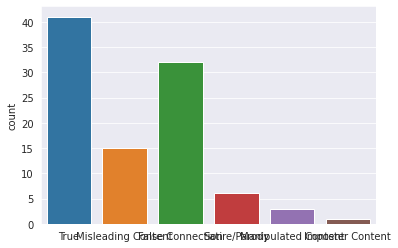

In [46]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("True")
    elif(i[1] == 1):
        l.append("Satire/Parody")
    elif(i[1] == 2):
        l.append("Misleading Content")
    elif(i[1] == 3):
        l.append("Imposter Content")
    elif(i[1] == 4):
        l.append("False Connection")
    elif(i[1] == 5):
        l.append("Manipulated Content")
sns.set_style('darkgrid')
sns.countplot(l)

Imposter content has a lower number examples so we need to balance the data 
(pendiente)

In [ ]:
def under_balance_data(data):
    
    return data

Text(0.5, 1.0, 'False Connection')

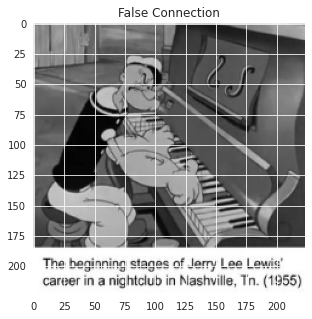

In [47]:
labels = ['True', 'Satire/Parody', 'False Connection', 'Imposter Content' , 'Manipulated Content', 'Misleading Content']
plt.figure(figsize = (5,5))
plt.imshow(train[2][0])
plt.title(labels[train[2][1]])

Text(0.5, 1.0, 'False Connection')

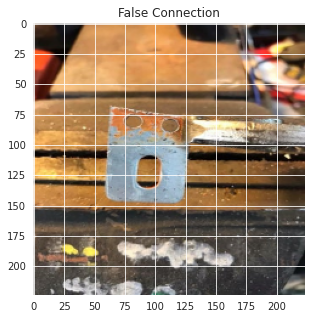

In [48]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

In [49]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [50]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [59]:
# Creating a Sequential model
model= Sequential()
model.add(Conv2D(kernel_size=(3,3), filters=32, activation='tanh', input_shape=(224,224,3,)))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='tanh'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='tanh'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='tanh'))

model.add(Flatten())

model.add(Dense(20,activation='relu'))
model.add(Dense(15,activation='relu'))
model.add(Dense(TYPE_CLASSIFICATION, activation = 'softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 220, 220, 30)      8670      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 110, 110, 30)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 108, 108, 30)      8130      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 30)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 52, 52, 30)       

In [63]:
opt = Adam(learning_rate=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train,y_train,epochs=50,batch_size=50,validation_data=(x_val,y_val))

Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 1.8653 - accuracy: 0.0204    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


2/2 [==============================] - 20s 11s/step - loss: 1.8653 - accuracy: 0.0204 - val_loss: 1.8519 - val_accuracy: 0.0202
Epoch 2/50
2/2 [==============================] - 21s 13s/step - loss: 1.8490 - accuracy: 0.0306 - val_loss: 1.8361 - val_accuracy: 0.0202
Epoch 3/50
2/2 [==============================] - 20s 11s/step - loss: 1.8347 - accuracy: 0.0306 - val_loss: 1.8234 - val_accuracy: 0.0606
Epoch 4/50
2/2 [==============================] - 19s 11s/step - loss: 1.8228 - accuracy: 0.0306 - val_loss: 1.8132 - val_accuracy: 0.0707
Epoch 5/50
2/2 [==============================] - 19s 11s/step - loss: 1.8122 - accuracy: 0.0510 - val_loss: 1.8050 - val_accuracy: 0.0909
Epoch 6/50
2/2 [==============================] - 19s 11s/step - loss: 1.8039 - accuracy: 0.0918 - val_loss: 1.7982 - val_accuracy: 0.1111
Epoch 7/50
2/2 [==============================] - 19s 11s/step - loss: 1.7971 - accuracy: 0.1122 - val_loss: 1.7927 - val_accuracy: 0.1313
Epoch 8/50
2/2 [======================